In [159]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import numpy as np
from tqdm import tqdm
from fastai import *
import torch
from torch import nn
from fastai.vision import *
%matplotlib inline
from fastai.callback import *
import cv2
import pandas as pd
import random
from IPython.display import display, Math

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()
    
#download weights and model
model = load_learner('')
model.load('best_model')


def img_to_pred(list_):
    list_of_pred = []
    for i, image in enumerate(list_):
        image = image/255
        image[image == 0.] = 255.
        image[image == 1.] = 0.
        cv2.imwrite(f'{i}.png', image)
        dct = {0:'!', 1:'(', 2:')',3:'+',5:'-',6:'0', 7 : '1', 
               8 : '2', 9: '3', 10 : '4', 11 : '5', 12 : '6', 
               13: '7', 14 :'8', 15:'9',16:'=',27:'x',
               79:'z',78:'y',73:'times',58:'neq', 4:','}
        pred_tensor = model.predict(open_image(f'{i}.png'))[2]
        #print(str( model.predict(open_image(f'{i}.png'))[0]))
        sorted_tensor = sorted(range(pred_tensor.shape[0]), key=lambda i: pred_tensor[i])[::-1]
        for i in sorted_tensor:
            if i in dct:
                pred = dct[i]
                break
        list_of_pred.append(pred)
    return list_of_pred

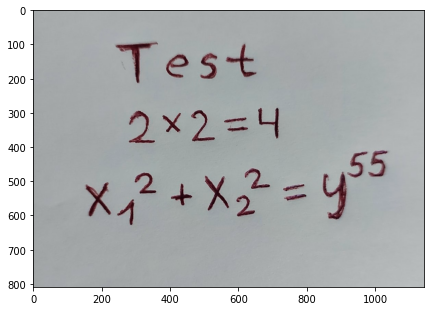

In [144]:
image_dir = 'images/'
file = "ft1.jpg"

img = cv2.imread(image_dir+file)
plt.figure(figsize=(7,7))
plt.imshow(img)

In [153]:
def cont_sort(cnts, method="l_r"):
    if method == "r_l":
        reverse = True
        i = 0
    if method == "b_t":
        reverse = True
        i = 1
    if method == "t_b":
        reverse = False
        i = 1
    if method == "l_r":
        reverse = False
        i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

def extract_line(image, param1=0.7, param2=0.002, show = True):
    img = image.copy()
    H,W = img.shape[:2]
    
    #Image to grey image and blured, to reduce noises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 3)
    
    #Binary thresholding
    _, threshed = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    
    #Erosion and dilation for noise removal 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    erosion = cv2.erode(threshed, kernel, iterations=1) 
    dilation = cv2.dilate(erosion,kernel,iterations = 1)
    
    # Find noise conturs and remove them from image
    contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)  
    cont_thresh = good_cont_thr(contours, param=param2)
    mask = np.ones(dilation.shape[:2], dtype="uint8") * 255
    for c in contours:
        if( cv2.contourArea(c)**2 < cont_thresh*0.5):
            cv2.drawContours(mask, [c], -1, 0, -1)
    
    cleaned_img = cv2.bitwise_and(dilation, dilation, mask=mask)
    plt.imshow(cleaned_img, cmap = 'gray')
    plt.axis
    #Dilating again for better detection
    dil_cleaned_img = cv2.dilate(cleaned_img,kernel,iterations = 5)
    
    #find boundaries of each line
    hist = cv2.reduce(dil_cleaned_img,1, cv2.REDUCE_AVG).reshape(-1)
    th = 1
    uppers = np.array([y for y in range(H-1) if hist[y]<=th and hist[y+1]>th])
    lowers = np.array([y for y in range(H-1) if hist[y]>th and hist[y+1]<=th])
    diff_1 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_1 = np.array([True if j > param1*(np.mean(diff_1)-np.std(diff_1)) else False for j in diff_1 ])
    uppers = uppers[diff_index_1]
    lowers = lowers[diff_index_1]
    diff_index = diff_index_1
    
    cleaned_orig_rec = cv2.cvtColor(dil_cleaned_img, cv2.COLOR_GRAY2BGR)
    col = (255,255,255)
    for left,right in zip(uppers[diff_index], lowers[diff_index]):
        cv2.rectangle(cleaned_orig_rec ,(0+10,left),(W-15,right),col,4)
        
    if(show == True):
        fig0 = plt.figure(figsize=(15,5))
        ax1 = fig0.add_subplot(1,2,1)
        ax1.set_title('Original Image')
        ax1.imshow(img)
        ax1.axis('off')
        
        ax2 = fig0.add_subplot(1,2,2)
        ax2.set_title('Preprocessed Image')
        ax2.imshow(cv2.cvtColor(dil_cleaned_img, cv2.COLOR_GRAY2RGB))
        ax2.axis('off')
        plt.show()
    
        fig1 = plt.figure(figsize=(15,5))
        plt.imshow(cv2.cvtColor(cleaned_orig_rec, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title('Line detection')
        plt.show()
    
    return cleaned_img,dil_cleaned_img, uppers[diff_index], lowers[diff_index]

def good_cont_thr(conts, param = 0.002):
    areas = []
    for c in conts:
        areas.append(cv2.contourArea(c)**2)
    thres = param * max(areas)
    return thres

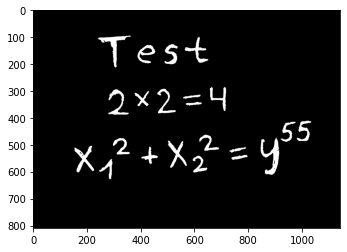

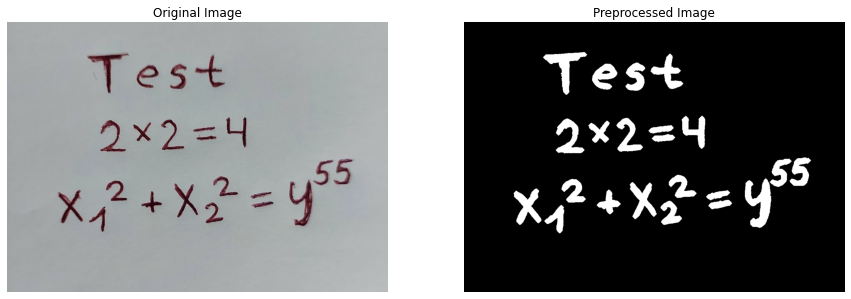

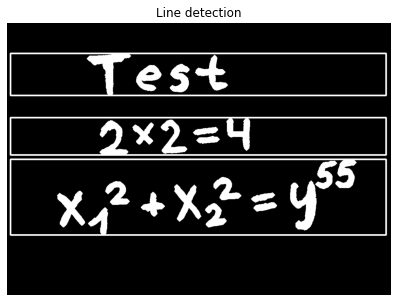

In [146]:
cleaned_orig,dil_orig,y1s,y2s = extract_line(img, param1=0.7, param2=0.002, show = True)
H,W = img.shape[:2]
x1s = [0]*len(y1s)
x2s = [W]*len(y1s)

df_lines = pd.DataFrame([y1s,y2s,x1s,x2s]).transpose()
df_lines.columns = ['y1','y2','x1','x2']

In [55]:
df_lines

,y1,y2,x1,x2
0,90,215,0,1142
1,281,392,0,1142
2,405,630,0,1142


In [170]:
def text_segment(Y1,Y2,X1,X2, img_clean,img_dil, show = True):
    img = img_dil[Y1:Y2,X1:X2].copy()
    L_H = Y2-Y1 
    # Find contours in line, remove noise ones, sort good ones from left to right
    contours,hierarchy = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)   
    ct_th = good_cont_thr(contours, param=0.005)
    cnts = []
    for c in contours:       
        if( cv2.contourArea(c)**2 > ct_th):
            cnts.append(c)
    contours_sorted,bounding_boxes = cont_sort(cnts,method="l_r")
    char_locs = []
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    char_type =[]
    images = []
    skip = []
    bounding_boxes = list(bounding_boxes)
    for i in range(len(contours_sorted)):#merge contours of "=" or 'i'
        x,y,w,h = bounding_boxes[i]
        char_locs.append([x,y,x+w,y+h])
        if i!=0:
            if (max(x,char_locs[-2][0])-min(x+w,char_locs[-2][2]))/(min(x,char_locs[-2][0])-max(x+w,char_locs[-2][2]))>0.5:
                xlu = min(char_locs[-1][0],char_locs[-2][0])
                ylu = min(char_locs[-1][1],char_locs[-2][1])
                xrd = max(char_locs[-1][2],char_locs[-2][2])
                yrd = max(char_locs[-1][3],char_locs[-2][3])
                skip.append(i-1)
                bounding_boxes[i] = [xlu,ylu,xrd-xlu,yrd-ylu]
    for i in range(len(contours_sorted)):
        if i in skip:
            continue
        x,y,w,h = bounding_boxes[i]
        exp = 0
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),2)
        m = max(w, h)
        scale = 39 / m
        new_h = int(h* scale)
        new_w = int(w* scale)
        offset = (int((45 - new_h) / 2), int((45 - new_w) / 2))
        out = np.zeros((45, 45))
        cell = cv2.resize(img_clean[Y1:Y2,X1:X2][max(y-2,0):y+h+1,x-1:x+w+1], (new_w, new_h), interpolation=cv2.INTER_AREA)
        out[offset[0]:offset[0] + cell.shape[0], offset[1]:offset[1] + cell.shape[1]] = cell
        _,out = cv2.threshold(out, 50, 255, cv2.THRESH_BINARY)
        if i!=0:
            #detect whether or not this is power
            if y+h < 1.25*(L_H*(1/2)) and y < bounding_boxes[last_regular][1] and h < 0.9 * bounding_boxes[last_regular][3]:
                exp = 1
                cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            #detect whether or not this is index
            if y+h > (L_H*(1/2)) and y > bounding_boxes[last_regular][1] and\
            y+h>bounding_boxes[last_regular][1]+bounding_boxes[last_regular][3] and h < 0.8 * bounding_boxes[last_regular][3]:
                exp = -1
                cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            
        if exp==0: 
            last_regular = i
        char_type.append(exp)
        images.append(out)
    if(show == True):        
        plt.figure(figsize=(15,8))   

        plt.axis("on")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show() 
    return char_type, images

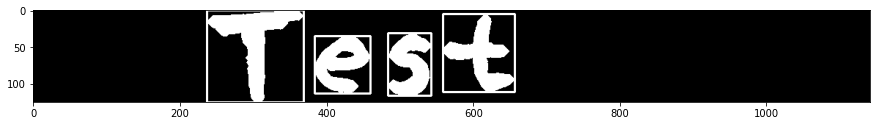

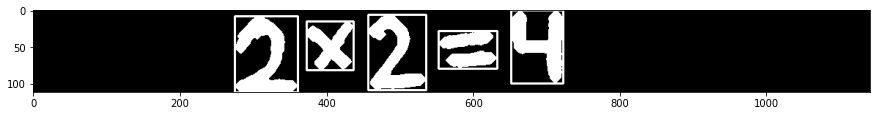

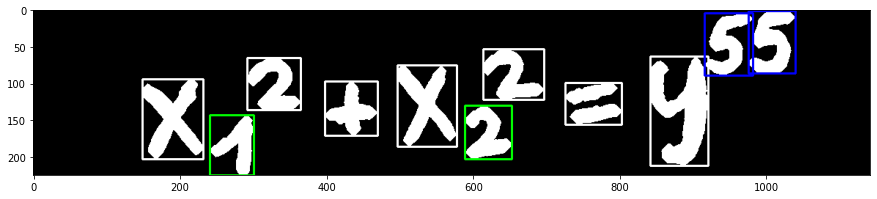

In [57]:
list_chars = list(df_lines.apply(lambda row: text_segment(row['y1'],row['y2'],row['x1'],row['x2'],
                                                          cleaned_orig,dil_orig,show=True), axis=1))

In [183]:
def pipe(path, show = True):
    img = cv2.imread(path)
    plt.imshow(img ,cmap ='gray')
    plt.axis('off')
    plt.show()
    
    cleaned_orig,dil_orig,y1s,y2s = extract_line(img, param1=0.7, param2=0.002, show = show)
    H,W = img.shape[:2]
    x1s = [0]*len(y1s)
    x2s = [W]*len(y1s)

    df_lines = pd.DataFrame([y1s,y2s,x1s,x2s]).transpose()
    df_lines.columns = ['y1','y2','x1','x2']
    
    list_chars = list(df_lines.apply(lambda row: text_segment(row['y1'], row['y2'], row['x1'], row['x2'],
                                                          cleaned_orig, dil_orig, show=show), axis=1))
    
#     for i in range(len(list_chars)):
#         print(f'line {i+1}')
#         print(f'indexes and powers:{list_chars[i][0]}')
#         print(f'predictions:{img_to_pred(list_chars[i][1])}')
        
    lines_with_tech = []
    for i in range(len(list_chars)):
        index = list_chars[i][0]
        lst_ = img_to_pred(list_chars[i][1])
        str_ = ''
        tmp = 0 
        for j in range(len(index)):
            if index[j] == 0:
                str_ += lst_[j]
            if index[j] == -1:
                if tmp == 0:
                    str_ += '_' + lst_[j]
                if tmp == -1:
                    str_ = str_[:-2] + '_{'+ str_[-1]
                    str_ +=  lst_[j] + '}'
            if index[j] == 1:
                if tmp == 0:
                    str_ += '^' + lst_[j]
                if tmp == -1:
                    str_ += '^' + lst_[j]
                if tmp == 1:
                    str_ = str_[:-2] + '^{' + str_[-1]
                    str_ +=  lst_[j] + '}'
            tmp = index[j] 
        #str_ += '$'
        lines_with_tech.append(str_)
    
    for line in lines_with_tech:
        display(Math(r'{}'.format(line)))